# Homework02: 
# Recommender System Using MovieLens Dataset

#### The goal of this homework is making movie recommendations using two basic CF algorithms: K-NN and Matrix Factorization.

In [2]:
#Import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV
from surprise import Dataset
from surprise import Reader
from sklearn.model_selection import KFold
import time as tm
import scipy.stats as spst
import scipy.sparse as spsp
%matplotlib inline
df=pd.read_csv('./ml-latest-small/ratings.csv')


In [3]:
reader = Reader(line_format='user item rating', sep=',', skip_lines=3, rating_scale=(1, 5))

### Ratings Dataset

In [4]:
df=pd.read_csv('./ml-latest-small/ratings.csv')
df=df.drop(['timestamp'],axis=1)
data=Dataset.load_from_df(df,reader=reader)

In [5]:
origin_size=len(df.values)
gap=int(origin_size/5)
new_size=np.arange(gap,origin_size,gap)

In [6]:
df.head(6)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0


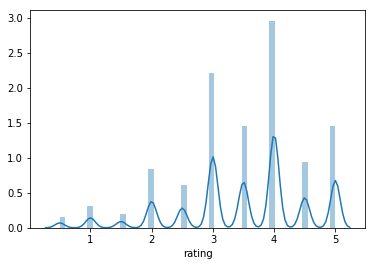

In [7]:
# Display distribution of rating
sns.distplot(df['rating'].fillna(df['rating'].median()))

There are more ratings in score 4 and 3 than that in other scores, showing that most of users are neutralistic. However, some users might rate their favorite movies only 4 stars while some rate it as 5 stars due to personality variance.

# Collaborative Filtering Recommendation Model
## KNN (Self-Implementation)

In [7]:
def trans_arr(result,data):
    arr=np.ones(len(data))
    for index,row in enumerate(data):
        i = int(row[0])-1
        j = int(row[1])-1
        try:
            arr[index]=result[i][j]
        except:
            arr[index]=0
    return arr

def MAE(arr,data):
    return np.mean(np.abs(data[:,-1]-arr))
def RMSE(arr,data):
    return (np.mean((data[:,-1]-arr)**2))**0.5

def get_neighbors(sim,k,i):
    sim[i]=-float('inf')
    return np.argsort(sim)[::-1][:k]
    
def knn_mean(df,k=40):
    n_user = max(df.userId.values)
    n_item = max(df.movieId.values)
    data = df.values[:,:-1]
    mu_user=df.groupby(['userId']).mean().rating.values
    R = np.zeros((n_user,n_item))
    result= np.zeros((n_user,n_item))
    norm_R =np.zeros((n_user,n_item))
    for row in data:
        i = int(row[0])-1
        j = int(row[1])-1
        R[i][j]=row[2]
        norm_R[i][j]=row[2]-mu_user[i]
    sim_matrix = np.corrcoef(R) 
    for i,row in enumerate(R):
        mu=mu_user[i]
        sim=sim_matrix[i]
        k_index=get_neighbors(sim,k,i)
        k_sim=sim[k_index]
        k_nb=norm_R[k_index,:]
        result[i]=(k_sim.T@k_nb/np.sum(k_sim)+mu)
    return result,data

In [8]:
def knn_cv(n_splits=5,k=40):
    df=pd.read_csv('./ml-latest-small/ratings.csv')
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 1)
    knn_train_mae=[]
    knn_train_mrse=[]
    knn_test_mae=[]
    knn_test_mrse=[]
    knn_time=[]
    for  tr,ts in kf.split(df):
        start = tm.time()
        train=df.iloc[tr]
        test=df.iloc[ts]
        result,train_data =knn_mean(train,k)
        test_data = test.values[:,:-1]
        train_arr=trans_arr(result,train_data)
        test_arr=trans_arr(result,test_data)
        knn_train_mae.append(MAE(train_arr,train_data))
        knn_train_mrse.append(RMSE(train_arr,train_data))
        knn_test_mae.append(MAE(test_arr,test_data))
        knn_test_mrse.append(RMSE(test_arr,test_data))
        end=tm.time()
        knn_time.append(end-start)
    return [np.mean(knn_train_mae),np.mean(knn_train_mrse),
            np.mean(knn_test_mae),np.mean(knn_test_mrse),
            np.mean(knn_time)]

In [9]:
neighbor_size=np.arange(40,100,15)
knn_result=[]
for k in neighbor_size:
    knn_result.append(knn_cv(5,k))

## Evaluate Knn (Self-Implementation)

In [10]:
knn_train_mae=[]
knn_train_rmse=[]
knn_test_mae=[]
knn_test_rmse=[]
knn_time=[]
for i in range(0,len(knn_result)):
    knn_train_mae.append(knn_result[i][0])
    knn_train_rmse.append(knn_result[i][1])
    knn_test_mae.append(knn_result[i][2])
    knn_test_rmse.append(knn_result[i][3])
    knn_time.append(knn_result[i][4])

### Fitting time vs. Neighbor size 

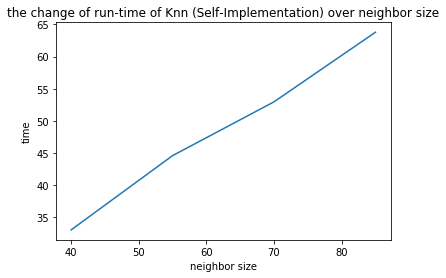

In [11]:
plt.title("the change of run-time of Knn (Self-Implementation) over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("time")
sns.lineplot(neighbor_size, knn_time, palette="tab10")

The running time increases as k increases.

### Mean_Absolute _Error (MAE) & Root Mean Squared Error (RMSE)
#### Primary accuracy metric : MAE

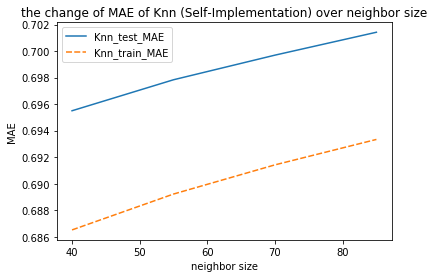

In [12]:
Knn_MAE = pd.DataFrame(np.column_stack([knn_test_mae, knn_train_mae]),columns=['Knn_test_MAE', 'Knn_train_MAE'])
Knn_MAE.index = neighbor_size
plt.title("the change of MAE of Knn (Self-Implementation) over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("MAE")
sns.lineplot(data = Knn_MAE, palette="tab10")

Observation :
The MAE of both train and test data increase as the neighbor size increases.

#### Secondary accuracy metric: RMSE

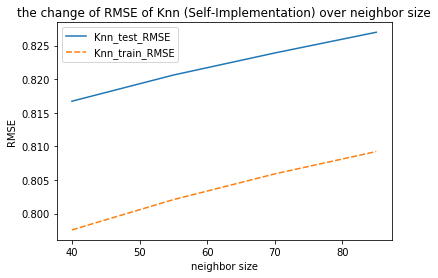

In [13]:
Knn_RMSE = pd.DataFrame(np.column_stack([knn_test_rmse, knn_train_rmse]),columns=['Knn_test_RMSE', 'Knn_train_RMSE'])
Knn_RMSE.index = neighbor_size
plt.title("the change of RMSE of Knn (Self-Implementation) over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("RMSE")
sns.lineplot(data = Knn_RMSE, palette="tab10")

Observation :
The RMSE of both train and test data increase as the neighbor size increases.

## KNN by surprise with baseline added

In [14]:
Knn_time = []
Knn_train_MAE=[]
Knn_test_MAE=[]
Knn_train_RMSE=[]
Knn_test_RMSE=[]

for k in neighbor_size:    
    algo=KNNBaseline(k=k)
    c_v=cross_validate(algo, data,cv=10, verbose=True,return_train_measures =True)
    Knn_time.append(np.mean(c_v['fit_time']))
    Knn_train_MAE.append(np.mean(c_v['train_mae']))
    Knn_test_MAE.append(np.mean(c_v['test_mae']))
    Knn_train_RMSE.append(np.mean(c_v['train_rmse']))
    Knn_test_RMSE.append(np.mean(c_v['test_rmse']))
knn_result=[Knn_time,Knn_train_MAE,Knn_test_MAE,Knn_train_RMSE,Knn_test_RMSE]  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

## Evaluate Knn by surprise
### Fitting time vs. Neighbor size 

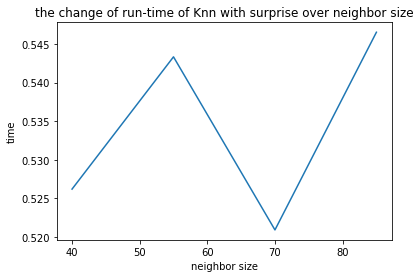

In [15]:
plt.title("the change of run-time of Knn with surprise over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("time")
sns.lineplot(neighbor_size, Knn_time, palette="tab10")

As shown above, when k is around 55, the fitting time is highest, meaning that the model is most complex at this neighbor size. The lowest fitting time is at k =75 approximately. While the run time of KNN without baseline is monotonically increasing by the increment of k. 


### Mean_Absolute _Error (MAE) & Root Mean Squared Error (RMSE)

#### Primary accuracy metric : MAE

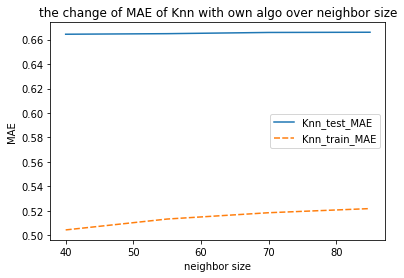

In [16]:
Knn_MAE = pd.DataFrame(np.column_stack([Knn_test_MAE, Knn_train_MAE]),columns=['Knn_test_MAE', 'Knn_train_MAE'])
Knn_MAE.index = neighbor_size
plt.title("the change of MAE of Knn with own algo over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("MAE")
sns.lineplot(data = Knn_MAE, palette="tab10")

#### Secondary accuracy metric: RMSE

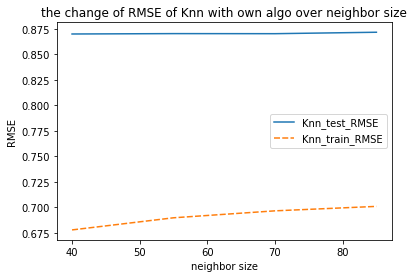

In [22]:
Knn_RMSE = pd.DataFrame(np.column_stack([Knn_test_RMSE, Knn_train_RMSE]),columns=['Knn_test_RMSE', 'Knn_train_RMSE'])
Knn_RMSE.index = neighbor_size
plt.title("the change of RMSE of Knn with own algo over neighbor size")
plt.xlabel("neighbor size")
plt.ylabel("RMSE")
sns.lineplot(data = Knn_RMSE, palette="tab10")

#### The comparison of MAE and RMSE:

1. Since the errors are squared before taking averages, some large errors would be given higher weights. When large errors are undesirable, using RMSE to eveluate the model would be useful. RMSE increases with the variance of the frequency distribution of error magnitudes.

2. RMSE has a tendency to be increasingly larger than MAE as the test sample size increases. So this is a problem when comparing RMSE computed from different test sample sizes. 

#### The results of MAE and RMSE for our model:
We can use both MAE and RMSE to eveluate the model.

As the plot showing, MAE is much less than RMSE, which is normal. This also indicates that there are some large error outliers of the results. 

The large errors in the results means that our recommender predict completely wrong rating scores so that some users would get recommendations on movies that they don't like, which is unexpected from us. In this case, there is a approximately 0.2 difference between MAE and RMSE, which indicates that there is about 20% variance in the individual errors in the sample.




### How  does Data size impact the accuracy of KNN?

Now we are trying to test how this model changes by the input data size.



In [30]:
#gridient search for optimal K value
param_grid = {'k': neighbor_size}
knn_gs=GridSearchCV(KNNBaseline,param_grid)
knn_gs.fit(data)

bestk = knn_gs.best_params['mae']['k']

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [31]:
knn_size_effect=[]
Knn_time = []
Knn_train_MAE=[]
Knn_test_MAE=[]
Knn_train_RMSE=[]
Knn_test_RMSE=[]
for n in new_size:
    new_df=df.sample(n=n)
    data=Dataset.load_from_df(new_df,reader=reader)
    algo=KNNBaseline(k=bestk)
    c_v=cross_validate(algo, data,cv=10, verbose=True,return_train_measures =True)
    Knn_time.append(np.mean(c_v['fit_time']))
    Knn_train_MAE.append(np.mean(c_v['train_mae']))
    Knn_test_MAE.append(np.mean(c_v['test_mae']))
    Knn_train_RMSE.append(np.mean(c_v['train_rmse']))
    Knn_test_RMSE.append(np.mean(c_v['test_rmse']))
knn_size_effect=[Knn_time,Knn_train_MAE,Knn_test_MAE,Knn_train_RMSE,Knn_test_RMSE]  


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8730  0.8770  0.8644  0.8660  0.8737  0.8675  0.8635  0.8653  0.8717  0.8651  0.8687  0.0045  
MAE (testset)     0.6693  0.6698  0.6605  0.6658  0.6663  0.6634  0.6557  0.6607  0.6638  0.6614  0.6637  0.0041  
RMSE (trainset)   0.6708  0.6713  0.6716  0.6715  0.6711  0.6713  0.6716  0.6724  0.6719  0.6719  0.6715  0.0004  
MAE (trainset)    0.4991  0.4994  0.4996  0.4996  0.4991  0.4

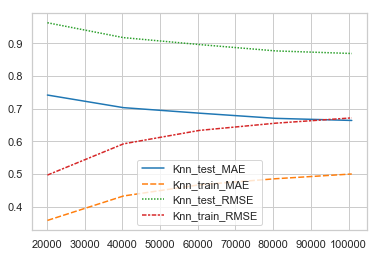

In [35]:
Knn_newsize_metrics = pd.DataFrame(np.column_stack([Knn_test_MAE, Knn_train_MAE,Knn_test_RMSE, Knn_train_RMSE]),
                   columns=['Knn_test_MAE', 'Knn_train_MAE','Knn_test_RMSE', 'Knn_train_RMSE'])
Knn_newsize_metrics.index = new_size
plt.title("the evaluation metrics change when changing model size")
plt.xlabel("model size")
plt.ylabel("evaluation metrics")
sns.lineplot(data = Knn_newsize_metrics, palette="tab10")

As the plot showing, the larger the neigbor size, the less MAE and RMSE.  But we cannot choose a large k to fit the model since the MAE and RMSE of train data are getting larger, which indicates overfitting. 

### How does Data size impact the run-time of KNN?

In [1]:
Knn_newsize_time = pd.DataFrame(Knn_time,columns=['Knn_time'])
Knn_newsize_time.index = new_size
plt.title("the run-time change when changing model size")
plt.xlabel("model size")
plt.ylabel("run-time")
sns.lineplot(data = Knn_newsize_time, palette="tab10")

NameError: name 'pd' is not defined

## Coverage on training and test data


We have 610 users, 193609 items and 100836 ratings.


# Model-Based Collaborative Filtering
## NMF(Self-Implementation)

In [8]:
def update_matrix_fast(U,V,X_list,gamma_U_params):
    #lambda_u -> u_{i,:} -> x_ij <- (v^*)_{j,:} <- lambda_v
    #Multiplicative method 
    A,B = gamma_U_params['a'],gamma_U_params['b']
    m,d = U.shape
    _,n = V.shape
    n_obs = X_list.shape[0]
    UV_sp = np.zeros(n_obs)
    ind_i = X_list[:,0].astype('int')
    ind_j = X_list[:,1].astype('int')
    UV_sp = np.sum(U[ind_i,:]*(V[:,ind_j].T),axis=1)
    X_UV = spsp.csc_matrix((X_list[:,-1]/UV_sp,(ind_i,ind_j)),shape = (m,n))#gradient
    M = spsp.csc_matrix((np.ones(n_obs),(ind_i,ind_j)),shape = (m,n))
    part1 = (A+np.multiply(U,(X_UV@(V.T))))
    part2 = (A/B+M@(V.T))
    U_new = part1/part2
    return(U_new)

def list_to_mat(data,dims):
    #parse data into matrix
    m,n = dims
    n_obs = len(data[:,0])
    out1 = np.zeros((m,n))
    out2 = np.zeros((m,n))
    for ind in range(n_obs):
        i,j = data[ind,:2]
        i = int(i)
        j = int(j)
        out1[i,j] = data[ind,-1]
        out2[i,j] = 1   
    return(out1,out2)

def rand_col_init(X,d):
    #random column initialization as given in Langville 2014
    m,n = X.shape
    shuffled_n = list(range(n))
    np.random.shuffle(shuffled_n)
    U = np.zeros((m,d))
    set_size = int(m/d)
    for i in range(d):#shuffle col for U as sum of random cols(of size m/d) in X. This will compress n into d col randomly
        try:
            U[:,i] = np.sum(X[:,shuffled_n[int(i*set_size):int((i+1)*set_size)]],axis = 1)
        except IndexError:
            U[:,i] = np.sum(X[:,shuffled_n[int(i*set_size):]],axis = 1)
    
    for i in range(d):#check if the whole col has 0. replace it of random variable from uniform dist.
        bool_slice = U[:,i] == 0
        n_neq0 = sum(bool_slice)
        U[bool_slice,i] = spst.uniform.rvs(0,5,size = n_neq0)    
    return(U)

In [9]:
def Poisson_pmf(data,dims,factors,U_params={'a':1,'b':1}, V_params={'a':1,'b':1}, T=100):
    m,n = dims
    d = factors
    n_obs = len(data[:,0])    
    data_T = data[:,[1,0,2]]    
    mat_data, mat_mask = list_to_mat(data,dims)
    U_0=rand_col_init(mat_data,d)
    V_0=rand_col_init(mat_data.T,d).T
    U = U_0
    V = V_0
    for t in range(T):        
        U = update_matrix_fast(U,V,data,U_params)
        V = update_matrix_fast(V.T,U.T,data_T,V_params).T        
    return(U,V)

In [10]:
def predict(test_set,U,V):
    i_obs = test_set[:,0].astype('int')
    j_obs = test_set[:,1].astype('int')
    UV_obs = np.sum(U[i_obs,:]*V[:,j_obs].T,axis=1)
    diff = (test_set[:,-1]-UV_obs)
    return(np.mean(np.abs(diff)),(np.mean(diff**2))**0.5)

def nmf_cv(n_splits=5,factors=15):
    df=pd.read_csv('./ml-latest-small/ratings.csv')
    ratings = df.values
    m,n = int(ratings[:,0].max()+1),int(ratings[:,1].max()+1)
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 1)
    nmf_train_mae=[]
    nmf_train_mrse=[]
    nmf_test_mae=[]
    nmf_test_mrse=[]
    nmf_time=[]
    for  tr,ts in kf.split(df):
        start = tm.time()
        train=df.iloc[tr].values
        test=df.iloc[ts].values
        train[:,:2] -= 1
        train = train[:,:-1]
        test[:,:2] -= 1
        test = test[:,:-1]
        U,V=Poisson_pmf(train,(m,n),factors,T=100)
        ts_mae,ts_mrse=predict(test,U,V)
        tr_mae,tr_mrse=predict(train,U,V)
        end = tm.time()
        nmf_train_mae.append(tr_mae)
        nmf_train_mrse.append(tr_mrse)
        nmf_test_mae.append(ts_mae)
        nmf_test_mrse.append(ts_mrse)
        nmf_time.append(end-start)
    return [np.mean(nmf_train_mae),np.mean(nmf_train_mrse),
            np.mean(nmf_test_mae),np.mean(nmf_test_mrse),
            np.mean(nmf_time)]

In [11]:
latent_dimensions=np.arange(2,20,5)
nmf_result=[]
for d in latent_dimensions:
    nmf_result.append(nmf_cv(factors=d))

In [12]:
nmf_result

[[0.5889375409692416,
  0.7723765017214592,
  0.6742074474795985,
  0.88023950643188,
  4.036520719528198],
 [0.5409264984771827,
  0.7061217098435877,
  0.6735395677908395,
  0.8822570375542412,
  7.216719388961792],
 [0.5552511439577368,
  0.7299650872423525,
  0.6702769440652661,
  0.8803789889562538,
  10.391195964813232],
 [0.5938639065012299,
  0.7826008433495002,
  0.6809962875303553,
  0.8968260760772571,
  13.51186203956604]]

## Evaluate NMF (Self-Implementation)

In [15]:
nmf_train_mae=[]
nmf_train_rmse=[]
nmf_test_mae=[]
nmf_test_rmse=[]
nmf_time=[]
for i in range(0,len(nmf_result)):
    nmf_train_mae.append(nmf_result[i][0])
    nmf_train_rmse.append(nmf_result[i][1])
    nmf_test_mae.append(nmf_result[i][2])
    nmf_test_rmse.append(nmf_result[i][3])
    nmf_time.append(nmf_result[i][4])

### Fitting time vs. latent dimensions

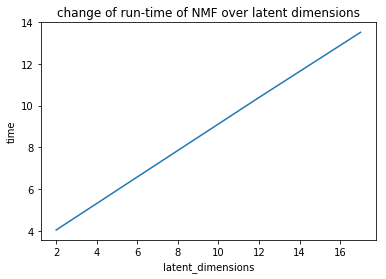

In [22]:
plt.title("change of run-time of NMF over latent dimensions")
plt.xlabel("latent_dimensions")
plt.ylabel("time")
sns.lineplot(latent_dimensions, nmf_time, palette="tab10")

### Mean_Absolute _Error (MAE) & Root Mean Squared Error (RMSE)
#### primary accuracy metric : MAE

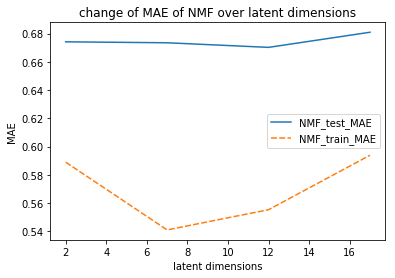

In [24]:
NMF_MAE = pd.DataFrame(np.column_stack([nmf_test_mae, nmf_train_mae]),columns=['NMF_test_MAE', 'NMF_train_MAE'])
NMF_MAE.index = latent_dimensions
plt.title("change of MAE of NMF over latent dimensions")
plt.xlabel("latent dimensions")
plt.ylabel("MAE")
sns.lineplot(data = NMF_MAE, palette="tab10")

#### secondary accuracy metric: RMSE

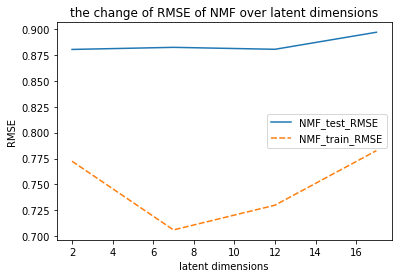

In [25]:
NMF_RMSE = pd.DataFrame(np.column_stack([nmf_test_rmse, nmf_train_rmse]),columns=['NMF_test_RMSE', 'NMF_train_RMSE'])
NMF_RMSE.index = latent_dimensions
plt.title("the change of RMSE of NMF over latent dimensions")
plt.xlabel("latent dimensions")
plt.ylabel("RMSE")
sns.lineplot(data = NMF_RMSE, palette="tab10")

# SVD by surprise

In [27]:
learning_rate=np.arange(0.001,0.01,0.002)
regularization=np.arange(0.01,0.1,0.02)
n_factors=np.arange(50,200,50)
n_epochs=np.arange(10,100,20)

svd_result=[]
for lr in learning_rate:
    SVD_time = []
    SVD_train_MAE=[]
    SVD_test_MAE=[]
    SVD_train_RMSE=[]
    SVD_test_RMSE=[]
    
    for reg in regularization:
        algo=SVD(n_epochs =50,lr_all=lr,reg_all=reg)
        c_v=cross_validate(algo, data,cv=10, verbose=True,return_train_measures =True)
        SVD_time.append(np.mean(c_v['fit_time']))
        SVD_train_MAE.append(np.mean(c_v['train_mae']))
        SVD_test_MAE.append(np.mean(c_v['test_mae']))
        SVD_train_RMSE.append(np.mean(c_v['train_rmse']))
        SVD_test_RMSE.append(np.mean(c_v['test_rmse']))
    svd_result.append([SVD_time,SVD_train_MAE,SVD_test_MAE,SVD_train_RMSE,SVD_test_RMSE])


Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8730  0.8637  0.8863  0.8840  0.8887  0.8776  0.8880  0.8734  0.8913  0.8742  0.8800  0.0085  
MAE (testset)     0.6702  0.6692  0.6835  0.6828  0.6863  0.6733  0.6835  0.6720  0.6824  0.6728  0.6776  0.0063  
RMSE (trainset)   0.7622  0.7634  0.7605  0.7595  0.7576  0.7582  0.7604  0.7610  0.7606  0.7625  0.7606  0.0017  
MAE (trainset)    0.5888  0.5890  0.5872  0.5865  0.5851  0.5859  0.5877  0.5877  0.5876  0.5886  0.5874  0.0012  
Fit time          15.07   15.24   15.14   15.08   15.32   14.71   14.77   15.12   15.22   14.71   15.04   0.21    
Test time         0.07    0.06    0.12    0.13    0.06    0.06    0.07    0.06    0.07    0.06    0.08    0.02    
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fol

KeyboardInterrupt: 

In [29]:
svd_result

[[[15.293750190734864,
   14.94609625339508,
   14.946623635292053,
   14.976887035369874,
   14.889759254455566],
  [0.5878614863561233,
   0.606283734843424,
   0.6174699439785853,
   0.6252736268212058,
   0.6308323111069642],
  [0.6768896006221607,
   0.6751037754826635,
   0.6752811370158377,
   0.6750017440552366,
   0.6756663356229016],
  [0.7614167909815415,
   0.7849014210413776,
   0.7994625893790019,
   0.8094448863568615,
   0.816580190690957],
  [0.8793295542076776,
   0.8764455277370816,
   0.8765410887708927,
   0.876090822781871,
   0.8763894673389556]],
 [[14.83118748664856,
   15.415873265266418,
   15.11498761177063,
   14.540412735939025,
   14.364144492149354],
  [0.3281862596663627,
   0.4250137473129982,
   0.4938101659966515,
   0.5394943473554509,
   0.5709045294991356],
  [0.6788651514395333,
   0.6612879908149056,
   0.6577744226058407,
   0.6585936401964241,
   0.661093546395092],
  [0.4266278234119424,
   0.544297532401491,
   0.6329143638043581,
   0.69343

## Evaluate SVD by surprise

In [30]:
svd_time = []
svd_train_MAE = []
svd_test_MAE = []
svd_train_RMSE = []
svd_test_RMSE = []
for row in svd_result:
    svd_time.append(row[0])
    svd_train_MAE.append(row[1])
    svd_test_MAE.append(row[2])
    svd_train_RMSE.append(row[3])
    svd_test_RMSE.append(row[4])

### Fitting time vs. hyper-parameters

In [31]:
svd_time = pd.DataFrame(svd_time)
svd_time.index = learning_rate.round(3)
svd_time.index.name = 'learning_rate'
svd_time.columns = regularization.round(2)
svd_time.columns.name = 'regularization'

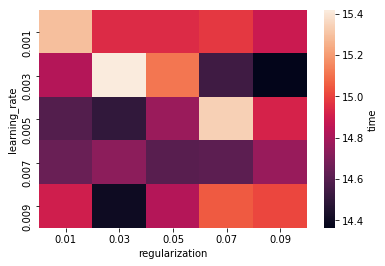

In [32]:
sns.heatmap(data = svd_time,cbar_kws={'label': 'time'})

### Mean_Absolute _Error (MAE) & Root Mean Squared Error (RMSE)
#### primary accuracy metric : MAE

In [33]:
svd_test_MAE = pd.DataFrame(svd_test_MAE)
svd_test_MAE.index = learning_rate.round(3)
svd_test_MAE.index.name = 'learning_rate'
svd_test_MAE.columns = regularization.round(2)
svd_test_MAE.columns.name = 'regularization'

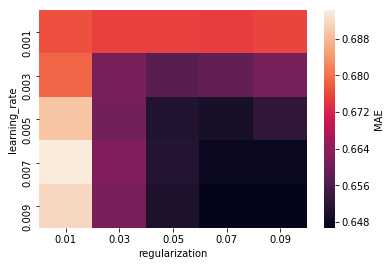

In [34]:
sns.heatmap(data = svd_test_MAE,cbar_kws={'label': 'MAE'})

#### secondary accuracy metric : RMSE

In [35]:
svd_test_RMSE = pd.DataFrame(svd_test_RMSE)
svd_test_RMSE.index = learning_rate.round(3)
svd_test_RMSE.index.name = 'learning_rate'
svd_test_RMSE.columns = regularization.round(2)
svd_test_RMSE.columns.name = 'regularization'

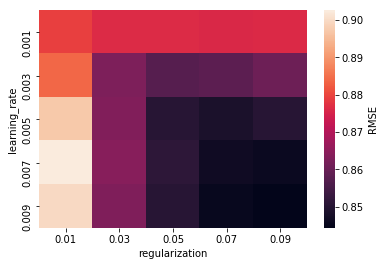

In [36]:
sns.heatmap(data = svd_test_RMSE,cbar_kws={'label': 'RMSE'})

### How does Data size impact the accuracy of SVD?

In [41]:
param_grid = {'lr_all': learning_rate,'reg_all':regularization}
svd_gs=GridSearchCV(SVD,param_grid)
svd_gs.fit(data)

bestlr = svd_gs.best_params['mae']['lr_all']
bestreg=svd_gs.best_params['mae']['reg_all']

In [42]:
SVD_time = []
SVD_train_MAE=[]
SVD_test_MAE=[]
SVD_train_RMSE=[]
SVD_test_RMSE=[]
SVD_size_effect=[]
for n in new_size:
    new_df=df.sample(n=n)
    data=Dataset.load_from_df(new_df,reader=reader)
    algo=SVD(n_epochs =50,lr_all=bestlr,reg_all=bestreg)
    c_v=cross_validate(algo, data,cv=10, verbose=True,return_train_measures =True)
    SVD_time.append(np.mean(c_v['fit_time']))
    SVD_train_MAE.append(np.mean(c_v['train_mae']))
    SVD_test_MAE.append(np.mean(c_v['test_mae']))
    SVD_train_RMSE.append(np.mean(c_v['train_rmse']))
    SVD_test_RMSE.append(np.mean(c_v['test_rmse']))
SVD_size_effect.append([SVD_time,SVD_train_MAE,SVD_test_MAE,SVD_train_RMSE,SVD_test_RMSE])

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9031  0.9199  0.9220  0.9106  0.9321  0.9018  0.8951  0.9387  0.8871  0.9161  0.9126  0.0154  
MAE (testset)     0.6987  0.7053  0.7144  0.7023  0.7111  0.6912  0.6806  0.7167  0.6957  0.7090  0.7025  0.0107  
RMSE (trainset)   0.3246  0.3214  0.3247  0.3215  0.3230  0.3218  0.3221  0.3227  0.3220  0.3240  0.3228  0.0012  
MAE (trainset)    0.2550  0.2532  0.2552  0.2523  0.2538  0.2530  0.2530  0.2534  0.2527  0.2544  0.2536  0.0009  
Fit time          2.81    2.63    2.68    2.71    2.82    2.99    3.21    2.79    2.77    2.84    2.83    0.16    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fol

In [342]:
%store SVD_size_effect

Stored 'SVD_size_effect' (list)


In [43]:
bestlr

0.009000000000000001

In [44]:
bestreg

0.06999999999999999

In [45]:
SVD_size_effect

[[[2.825703763961792,
   5.547080683708191,
   8.237026929855347,
   11.580831670761109,
   14.405395221710204],
  [0.25359704368156943,
   0.29103409744674347,
   0.31899733066335634,
   0.34249580940766333,
   0.36291928616750707],
  [0.7025067628566097,
   0.6860331841677325,
   0.6702736199437369,
   0.6575217320661327,
   0.6459514326134578],
  [0.3227840906876074,
   0.37227287430596406,
   0.40943551726940647,
   0.441195335118295,
   0.46759323218033017],
  [0.9126430363816462,
   0.8927526186365793,
   0.8721704667860543,
   0.8586235960773985,
   0.8441885144961937]]]

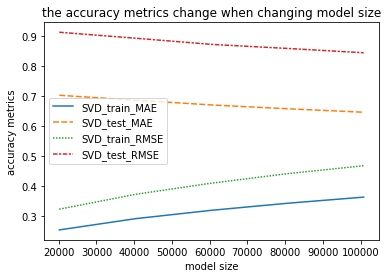

In [46]:
svd_newsize_metrics = pd.DataFrame(np.column_stack([SVD_train_MAE, SVD_test_MAE,SVD_train_RMSE, SVD_test_RMSE]),
                   columns=['SVD_train_MAE', 'SVD_test_MAE','SVD_train_RMSE', 'SVD_test_RMSE'])
svd_newsize_metrics.index = new_size
plt.title("the accuracy metrics change when changing model size")
plt.xlabel("model size")
plt.ylabel("accuracy metrics")
sns.lineplot(data = svd_newsize_metrics, palette="tab10")

### How does Data size impact the run-time of SVD?

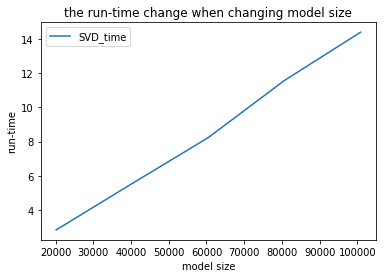

In [47]:
SVD_newsize_time = pd.DataFrame(SVD_time,columns=['SVD_time'])
SVD_newsize_time.index = new_size
plt.title("the run-time change when changing model size")
plt.xlabel("model size")
plt.ylabel("run-time")
sns.lineplot(data = SVD_newsize_time, palette="tab10")